Silakan unggah DUA file: 1) Objek yang dicari (kecil), 2) Gambar Adegan (Scene) (besar):


Saving images.jpeg to images.jpeg
Saving IMG-20240202-WA0113.jpg to IMG-20240202-WA0113 (2).jpg

          ANALISIS KINERJA DAN TOTAL MATCH

--- ALGORITMA: FAST+BRIEF ---
Total Match (Pasangan Terbaik): 250
Waktu Komputasi Total: 0.0525 detik


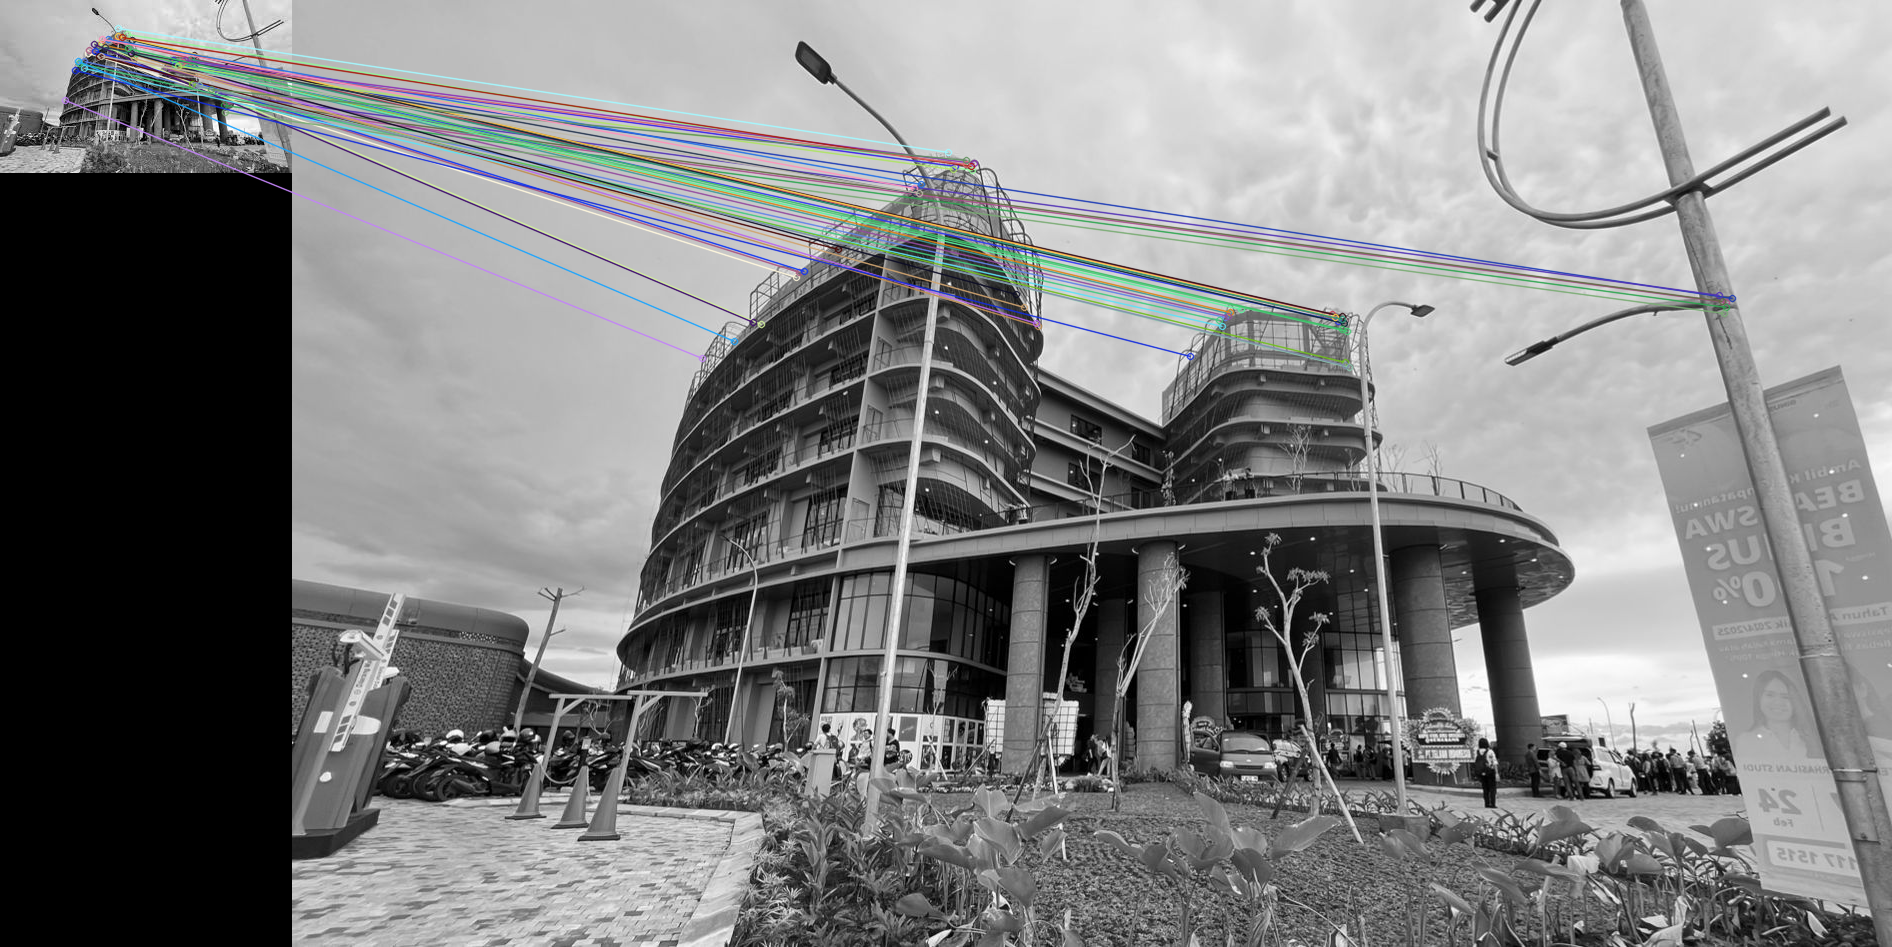


--- ALGORITMA: ORB ---
Total Match (Pasangan Terbaik): 435
Waktu Komputasi Total: 0.0710 detik


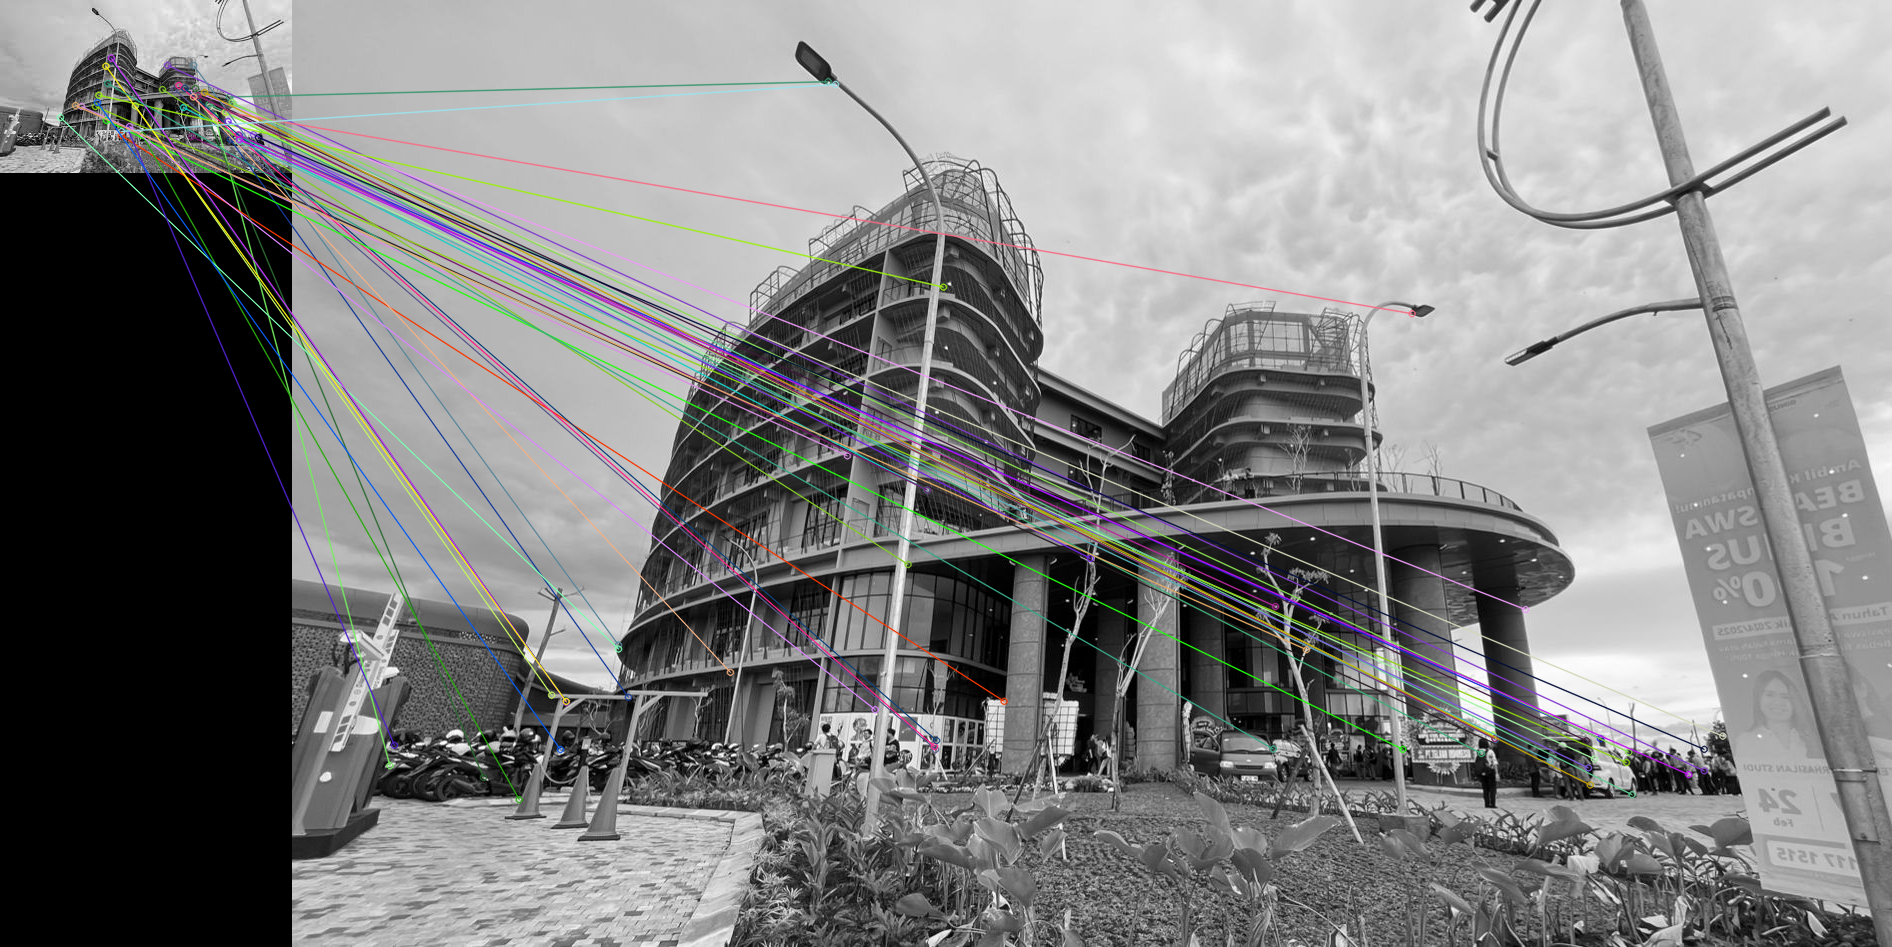


--- ALGORITMA: SIFT ---
Total Match (Pasangan Terbaik): 226
Waktu Komputasi Total: 0.3507 detik


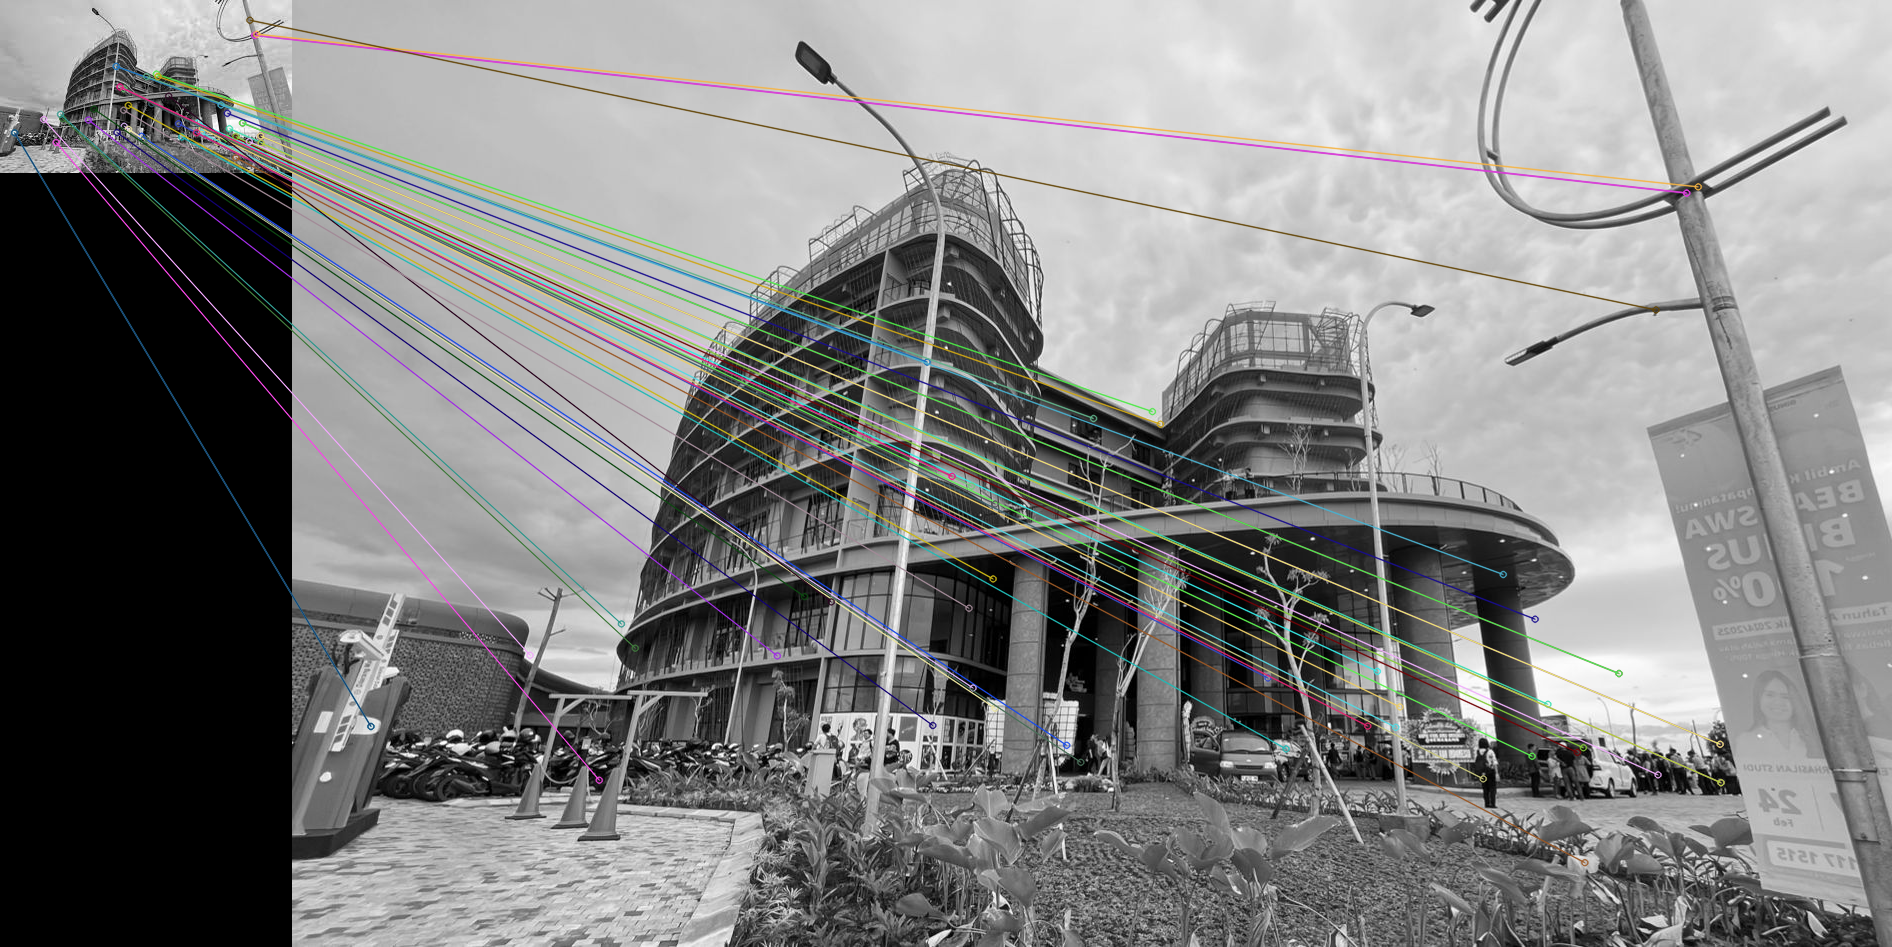

In [4]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import time

# --- 1. PROSES UPLOAD DUA FILE GAMBAR ---
print("Silakan unggah DUA file: 1) Objek yang dicari (kecil), 2) Gambar Adegan (Scene) (besar):")
uploaded = files.upload()

if len(uploaded) < 2:
    print("Error: Harap unggah minimal dua file gambar.")
else:
    file_names = list(uploaded.keys())

    # Memuat gambar objek (query) dan gambar adegan (train) dalam grayscale
    img_object = cv2.imdecode(np.frombuffer(uploaded[file_names[0]], np.uint8), cv2.IMREAD_GRAYSCALE)
    img_scene = cv2.imdecode(np.frombuffer(uploaded[file_names[1]], np.uint8), cv2.IMREAD_GRAYSCALE)

    if img_object is None or img_scene is None:
        print("Error: Salah satu atau kedua file tidak dapat dibaca sebagai gambar.")
    else:
        # PERBAIKAN ERROR: Mengubah grayscale ke BGR untuk visualisasi warna (DRAW MATCHES)
        img_object_color = cv2.cvtColor(img_object, cv2.COLOR_GRAY2BGR)
        img_scene_color = cv2.cvtColor(img_scene, cv2.COLOR_GRAY2BGR)

        # Inisialisasi list hasil
        results = {}
        MAX_FEATURES = 2000 # Batas fitur untuk perbandingan yang adil

        # -------------------------------------------------------------------
        # ALGORITMA 1: ORB (Oriented FAST & Rotated BRIEF) - Patokan Cepat
        # -------------------------------------------------------------------
        start_time_orb = time.time()

        orb = cv2.ORB_create(nfeatures=MAX_FEATURES)

        kp_orb_obj, des_orb_obj = orb.detectAndCompute(img_object, None)
        kp_orb_scene, des_orb_scene = orb.detectAndCompute(img_scene, None)

        if des_orb_obj is not None and des_orb_scene is not None:
            bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches_orb = bf_orb.match(des_orb_obj, des_orb_scene)
            matches_orb = sorted(matches_orb, key = lambda x:x.distance)

            end_time_orb = time.time()
            results['ORB'] = {
                'time': end_time_orb - start_time_orb,
                'matches': len(matches_orb),
                'img': cv2.drawMatches(img_object_color, kp_orb_obj, img_scene_color, kp_orb_scene,
                                       matches_orb[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            }
        else:
             results['ORB'] = {'time': time.time() - start_time_orb, 'matches': 0, 'img': np.zeros((100, 100, 3), np.uint8)}

        # -------------------------------------------------------------------
        # ALGORITMA 2: FAST + BRIEF (Implementasi Murni - Tanpa Orientasi/Skala)
        # -------------------------------------------------------------------
        start_time_brief = time.time()

        try:
            # 1. Detektor: Gunakan FAST untuk menemukan keypoints
            fast = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
            kp_brief_obj = fast.detect(img_object, None)
            kp_brief_scene = fast.detect(img_scene, None)

            # Batasi keypoints agar tidak melebihi MAX_FEATURES (untuk perbandingan adil)
            kp_brief_obj = kp_brief_obj[:MAX_FEATURES]
            kp_brief_scene = kp_brief_scene[:MAX_FEATURES]


            # 2. Deskriptor: Gunakan BRIEF untuk mendeskripsikan keypoints
            # Perhatikan: BRIEF membutuhkan 'opencv-contrib-python' (diasumsikan sudah ada di Colab)
            brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(bytes=32)
            kp_brief_obj, des_brief_obj = brief.compute(img_object, kp_brief_obj)
            kp_brief_scene, des_brief_scene = brief.compute(img_scene, kp_brief_scene)


            if des_brief_obj is not None and des_brief_scene is not None and len(kp_brief_obj) > 0 and len(kp_brief_scene) > 0:
                # 3. Pencocokan Fitur (NORM_HAMMING untuk BRIEF Biner)
                bf_brief = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
                matches_brief = bf_brief.match(des_brief_obj, des_brief_scene)
                matches_brief = sorted(matches_brief, key = lambda x:x.distance)

                # Hitung Waktu dan Jumlah Match
                end_time_brief = time.time()
                results['FAST+BRIEF'] = {
                    'time': end_time_brief - start_time_brief,
                    'matches': len(matches_brief),
                    'img': cv2.drawMatches(img_object_color, kp_brief_obj, img_scene_color, kp_brief_scene,
                                           matches_brief[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                }
            else:
                results['FAST+BRIEF'] = {'time': time.time() - start_time_brief, 'matches': 0, 'img': np.zeros((100, 100, 3), np.uint8)}

        except AttributeError:
             results['FAST+BRIEF'] = {'time': 0, 'matches': 0, 'img': np.zeros((100, 100, 3), np.uint8)}
             print("\nFAST+BRIEF ERROR: xfeatures2d (BRIEF) mungkin tidak tersedia di environment ini.")

        # -------------------------------------------------------------------
        # ALGORITMA 3: SIFT (Scale-invariant Feature Transform)
        # -------------------------------------------------------------------
        start_time_sift = time.time()

        try:
            sift = cv2.SIFT_create(nfeatures=MAX_FEATURES)

            kp_sift_obj, des_sift_obj = sift.detectAndCompute(img_object, None)
            kp_sift_scene, des_sift_scene = sift.detectAndCompute(img_scene, None)

            if des_sift_obj is not None and des_sift_scene is not None:
                bf_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
                matches_sift = bf_sift.match(des_sift_obj, des_sift_scene)
                matches_sift = sorted(matches_sift, key = lambda x:x.distance)

                end_time_sift = time.time()
                results['SIFT'] = {
                    'time': end_time_sift - start_time_sift,
                    'matches': len(matches_sift),
                    'img': cv2.drawMatches(img_object_color, kp_sift_obj, img_scene_color, kp_sift_scene,
                                           matches_sift[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                }
            else:
                results['SIFT'] = {'time': time.time() - start_time_sift, 'matches': 0, 'img': np.zeros((100, 100, 3), np.uint8)}

        except cv2.error:
            results['SIFT'] = {'time': 0, 'matches': 0, 'img': np.zeros((100, 100, 3), np.uint8)}
            print("\nSIFT ERROR: SIFT mungkin tidak tersedia di environment ini.")

        # -------------------------------------------------------------------
        # 4. MENAMPILKAN HASIL AKHIR DAN ANALISIS
        # -------------------------------------------------------------------

        print("\n=========================================================")
        print("          ANALISIS KINERJA DAN TOTAL MATCH")
        print("=========================================================")

        # Urutan yang logis: FAST+BRIEF (Paling Cepat/Rapuh) -> ORB (Cepat/Seimbang) -> SIFT (Paling Robust/Lambat)
        for name in ['FAST+BRIEF', 'ORB', 'SIFT']:
            if name in results:
                data = results[name]
                print(f"\n--- ALGORITMA: {name} ---")
                print(f"Total Match (Pasangan Terbaik): {data['matches']}")
                print(f"Waktu Komputasi Total: {data['time']:.4f} detik")
                cv2_imshow(data['img'])